In [84]:
# Load dependencies

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.models as models
import torch.optim as optim 
import os
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import torchattacks
from torchmetrics.functional.image import peak_signal_noise_ratio, structural_similarity_index_measure
import matplotlib.pyplot as plt
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [85]:
image_dim = 224
batch_size = 1

In [86]:
test_preprocessing = transforms.Compose([
    transforms.RandomResizedCrop((image_dim, image_dim)),
    transforms.ToTensor()
])

In [87]:
# Training and Validation dataset

print('===>> Preparing data...')
trash_test_dataset = torchvision.datasets.ImageFolder('dataset/trashbox/test', transform=test_preprocessing)
trash_test_loader = torch.utils.data.DataLoader(dataset=trash_test_dataset, shuffle=True, batch_size=batch_size)

===>> Preparing data...


In [88]:
samples, targets = next(iter(trash_test_loader))
samples, targets = samples.to(device), targets.to(device)

In [89]:
model = models.mobilenet_v3_small()
model.classifier = nn.Sequential(
    nn.Linear(in_features=576, out_features=1024, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1024, out_features=7, bias=True)
  )

model = model.to(device)

checkpoint = torch.load('./best_trained_models/best_NORMAL--Mobilenetv3Small.v1_epoch40.pth')

if 'module' in list(checkpoint['net'].keys())[0]:
    new_state_dict = {k.replace("module.", ""): v for k, v in checkpoint['net'].items()}
    model.load_state_dict(new_state_dict)
else:
    model.load_state_dict(checkpoint['net'])

model = model.to(device)
model.eval()


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [90]:
attack = torchattacks.PGD(model)
adv_samples = attack(samples, targets)

In [91]:
image_preview = samples[0].cpu().numpy()
adv_image_preview = adv_samples[0].cpu().numpy()

image_preview = np.transpose(image_preview, (1, 2, 0))
adv_image_preview = np.transpose(adv_image_preview, (1, 2, 0))

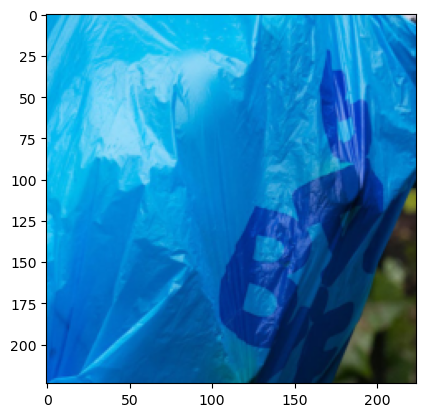

In [92]:
plt.imshow(image_preview)

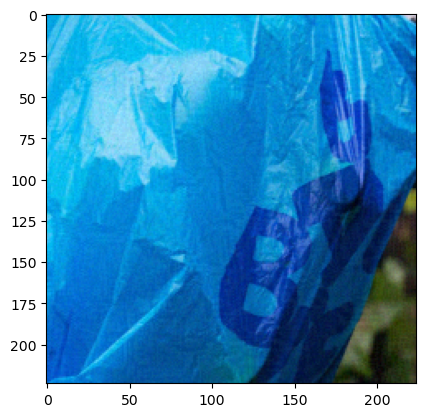

In [93]:
plt.imshow(adv_image_preview)

In [94]:
output_logits = model(samples)

output_probs = F.softmax(output_logits, dim=1)

classnames = [
    "cardboard",
    "e-waste",
    "glass",
    "medical waste",
    "metal",
    "plastic",
    "paper"
]
top1_index = torch.argmax(output_probs, dim=1)

top1_prob = output_probs[torch.arange(len(output_probs)), top1_index]

top1_prob_percentage = top1_prob * 100

print("Class Pred: ", top1_index, classnames[top1_index])
print("Pred. Percent:", top1_prob_percentage)


Class Pred:  tensor([6], device='cuda:0') paper
Pred. Percent: tensor([99.9995], device='cuda:0', grad_fn=<MulBackward0>)
